# Régressions discrètes

- *Auteurs:* Cristian Preda, Quentin Grimonprez
- *Date:* 16 mars 2021

Dans la suite, nous allons utiliser statsmodels.

Pour scikit-learn: [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pour faire une régression logistique ou multinomiale. Notez que la focntion LogisticRegression applique par défaut une pénalité l2, pour la régression logistique "classique", il faut préciser `penalty=None`.[sklearn.linear_model.PoissonRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html#sklearn.linear_model.PoissonRegressor) pour faire une régression de Poisson.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, auc, accuracy_score

plt.rcParams["figure.figsize"] = 12, 8

## Régression logistique

Modèle logit : log(p(y=1|X)/p(y=0|X)) = X * beta

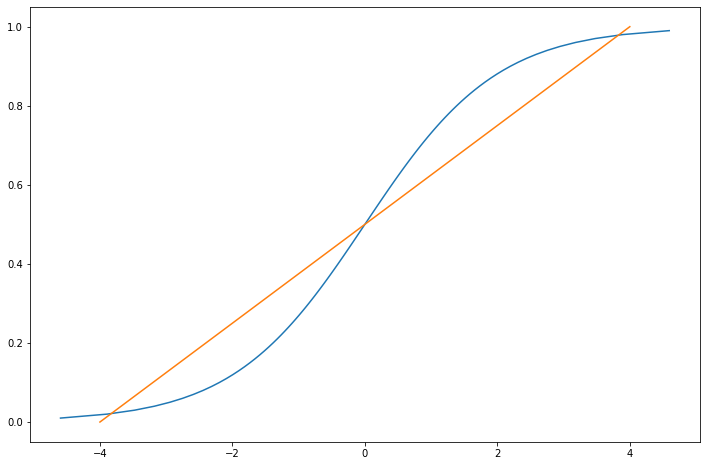

In [2]:
ax = sns.lineplot(x=np.log(np.arange(0.01, 1, 0.01)/(1-np.arange(0.01, 1, 0.01))), y=np.arange(0.01, 1, 0.01))
sns.lineplot(x=[-4, 4], y=[0, 1], ax=ax)
plt.show()

Infos sur les données : <https://www.statsmodels.org/stable/datasets/generated/spector.html>

Efficacité d'un programme d'instruction personnalisée

In [3]:
spector_data = sm.datasets.spector.load_pandas()

In [4]:
spector_data.data.head()

,GPA,TUCE,PSI,GRADE
0,2.66,20.0,0.0,0.0
1,2.89,22.0,0.0,0.0
2,3.28,24.0,0.0,0.0
3,2.92,12.0,0.0,0.0
4,4.00,21.0,0.0,1.0


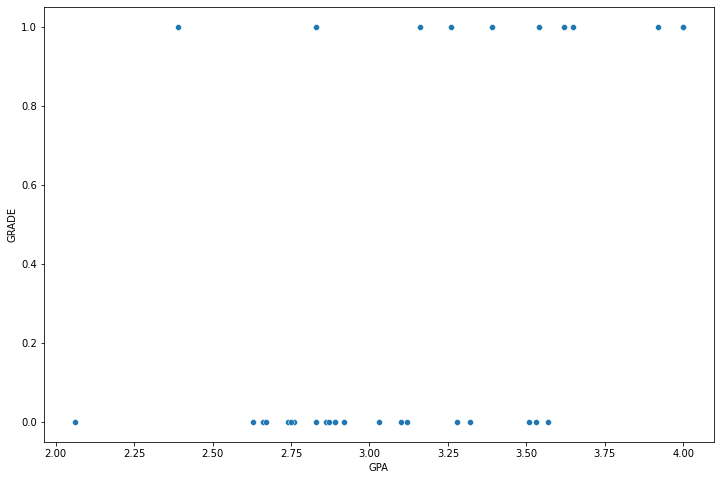

In [5]:
sns.scatterplot(x="GPA", y="GRADE", data=spector_data.data)
plt.show()

In [6]:
logit_mod = smf.logit("GRADE ~ PSI + GPA + TUCE", data=spector_data.data)
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.402801
         Iterations 7


In [7]:
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  GRADE   No. Observations:                   32
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            3
Date:                Wed, 16 Jun 2021   Pseudo R-squ.:                  0.3740
Time:                        10:00:57   Log-Likelihood:                -12.890
converged:                       True   LL-Null:                       -20.592
Covariance Type:            nonrobust   LLR p-value:                  0.001502
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.0213      4.931     -2.641      0.008     -22.687      -3.356
PSI            2.3787      1.065      2.234      0.025       0.292       4.465
GPA            2.8261      1.263      2.238      0.025       0.351       5.301
TUCE           0.0952      0.142      0.672      0.501      -0.182       0.373
==============================================================================
"""

La valeur **Pseudo R-squ.** dans le summary est le pseudo R2 de McFadden

In [8]:
logit_res.prsquared

0.3740382953726187

La valeur **LLR p-value** est la p-valeur d'un test de rapport de vraisemblance. Il teste si le modèle appris est mieux que le modèle nul (pas de variables explicatives). H0 : le modèle nul est meilleur. H1 : le modèle appris est meilleur.

In [9]:
logit_res.llr_pvalue

0.0015018786820365808

### Odd ratio

L'odd ratio (OR) permet de mesurer la relation entre une variable explicative et la réponse.
Un odd est : P(Y=1 | X=x)/(1 - P(Y=1 | X=x)). Un OR est le ratio entre deux odds P(Y=1 | X=1)/(1 - P(Y=1 | X=1)) / (P(Y=1 | X=0)/(1 - P(Y=1 | X=0))).

- si l’OR est significativement < 1 alors la variable explicative est un facteur  protecteur.
- si l’OR n’est pas significativement différent de 1, alors il n’y a pas de lien entre la réalisation (par exemple la maladie) et la variable explicative.
- si l’OR est significativement > 1 alors la variable explicative est un facteur de risque

L'OR correspond à l'exponentielle du coefficient estimé. Pour savoir s'il est significativement différent de 1, on regarde si le coefficient estimé est significativement différent de 0 ou non.


Dans notre cas, seul PSI et GPA ont un odd ratio significativement différent de 1.

In [10]:
np.exp(logit_res.params)

Intercept     0.000002
PSI          10.790732
GPA          16.879715
TUCE          1.099832
dtype: float64

#### Interprétation cas variable explicative binaire

PSI a un odd-ratio de 10.79. Donc si une personne suit le PSI (PSI = 1) alors elle a 10.79 fois plus de chance d'améliorer ses notes (GRAD=1) qu'une personne qui n'a pas suivi le PSI.

#### Interprétation cas variable explicative quantitative

GPA a un odd-ratio de 16.88. Donc une augmentation de 1 unité de GPA donne 16.88 fois plus de chances d'améliorer ses notes (GRAD=1).

### Prédiction

Dans fittedvalues, on retrouve les log ratio estimés.

In [11]:
logit_res.fittedvalues[:10]

0   -3.600734
1   -2.760413
2   -1.467914
3   -3.627206
4    0.281414
5   -3.320985
6   -3.603596
7   -2.912093
8   -2.079284
9    0.816587
dtype: float64

On peut les transformer en probabilité d'améliorer la note (P(Y=1|X))

In [12]:
1/(1 + np.exp(-logit_res.fittedvalues))[:10]

0    0.026578
1    0.059501
2    0.187260
3    0.025902
4    0.569893
5    0.034858
6    0.026504
7    0.051559
8    0.111127
9    0.693511
dtype: float64

ou les obtenir via la fonction predict

In [13]:
p = logit_res.predict()
p

array([0.02657799, 0.05950125, 0.18725993, 0.02590164, 0.56989295,
       0.03485827, 0.02650406, 0.051559  , 0.11112666, 0.69351131,
       0.02447037, 0.18999744, 0.32223955, 0.19321116, 0.36098992,
       0.03018375, 0.05362641, 0.03858834, 0.58987249, 0.66078584,
       0.06137585, 0.90484727, 0.24177245, 0.85209089, 0.83829051,
       0.48113304, 0.63542059, 0.30721866, 0.84170413, 0.94534025,
       0.5291172 , 0.11103084])

Pour transformer nos probabilités en label 0 ou 1, il faut fixer un seuil. Par exemple, si on fixe un seuil de 0.5, nos prédictions sont :

In [14]:
yPred = (p > 0.5).astype(int)
yPred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0])

Avec la fonction pred_table, on peut obtenir la table de confusion pour un seuil donné. Les vrais valeurs sont en lignes et les valeurs prédites en colonnes.

In [15]:
logit_res.pred_table(0.5)

array([[18.,  3.],
       [ 3.,  8.]])

In [16]:
accuracy_score(spector_data.data["GRADE"].values, yPred)

0.8125

cf. <https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values> pour calculer d'autres métriques

Comment trouver le seuil optimal ?

### Courbe ROC et AUC

La courbe ROC (receiver operating characteristic) permet d'évaluer la performance d'un classifieur binaire. Elle représente le taux de vrais positif (sensibilité) en fonction du taux de faux positifs (1-spécificité) pour différents seuils. Chaque point de cette courbe, nous donne la performance du classifieur pour un seuil donné. L'AUC (area under curve) est l'aire sous la courbe ROC. Une aire de 1 correspond à un classifieur parfait (car le meilleur classifieur passe par le point (0, 1)), une aire de 0, un classifieur qui prédit parfaitement le contraire. Un classifieur aléatoire à une AUC de 0.5.

In [17]:
spector_data.data["GRADE"].values

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.])

In [18]:
fpr, tpr, thresholds = roc_curve(spector_data.data["GRADE"].values, p)
roc_auc = auc(fpr, tpr)
roc_auc

0.8831168831168832

In [19]:
pd.DataFrame({"tpr": tpr, "fpr": fpr, "seuil": thresholds})

,tpr,fpr,seuil
0,0.000000,0.000000,1.945340
1,0.090909,0.000000,0.945340
2,0.181818,0.000000,0.904847
3,0.181818,0.047619,0.852091
4,0.636364,0.047619,0.635421
5,0.636364,0.095238,0.589872
6,0.727273,0.095238,0.569893
7,0.727273,0.142857,0.529117
8,0.818182,0.142857,0.481133
9,0.818182,0.333333,0.241772


Par exemple, un seuil de 0.53, nous donne un tpr de 0.73 et un fpr de 0.14.

Text(0.5, 1.0, 'Courbe ROC. AUC = 0.883')

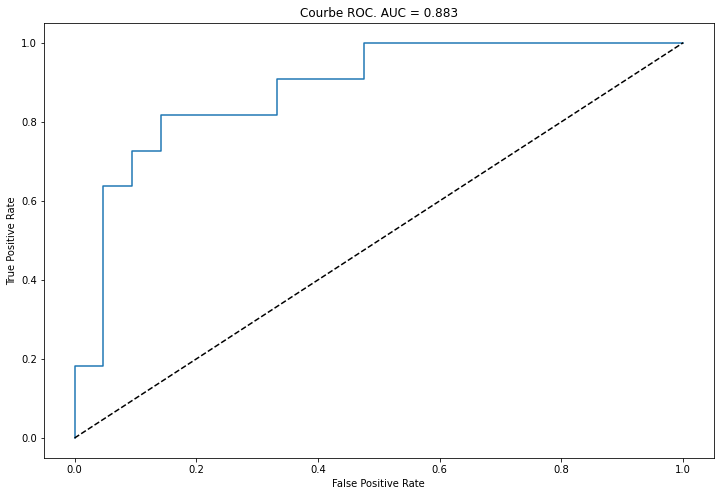

In [20]:
ax = sns.lineplot(x=fpr, y=tpr, estimator=None)
sns.lineplot(x = [0, 1], y = [0, 1], color="black", ls="--", ax=ax)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Courbe ROC. AUC = " + str(np.round(roc_auc, 3)))

Le seuil optimal est le seuil associé au point de la courbe le plus proche du point (0, 1) qui correspond à un classifieur parfait.

In [21]:
def findOptimalThreshold(tpr, fpr, thr):
    d = fpr**2 + (tpr-1)**2
    indMin = np.argmin(d)

    return thr[indMin], tpr[indMin], fpr[indMin]

In [22]:
thrHat, tprHat, fprHat = findOptimalThreshold(tpr, fpr, thresholds)
thrHat, tprHat, fprHat

(0.48113303625320397, 0.8181818181818182, 0.14285714285714285)

Text(0.5, 1.0, 'Courbe ROC. AUC = 0.8831168831168832')

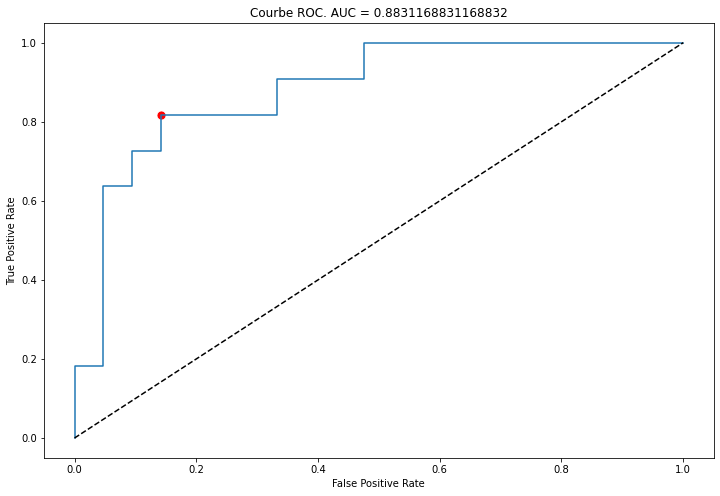

In [23]:
ax = sns.lineplot(x=fpr, y=tpr, estimator=None)
sns.lineplot(x=[0, 1], y=[0, 1], color="black", ls="--", ax=ax)
sns.scatterplot(x=[fprHat], y=[tprHat], color="red", s=80, ax=ax)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Courbe ROC. AUC = " + str(roc_auc))

## Régression Multinomiale

La régression multinomiale est l'extension de la régression logistique pour une variable réponse avec k > 2 modalités. La version implémentée dans statsmodels est celle du One vs All. Elle consiste à utiliser une modalité de la variable réponse comme référence et de faire k - 1 modèles de régression logistique chacun modélisant un log ratio différent : log(p(y=j|X)/p(y=ref|X))

Infos sur les données : <https://www.statsmodels.org/stable/datasets/generated/anes96.html>

Études sur les élections américaines de 1996

In [24]:
anes_data = sm.datasets.anes96.load_pandas()
anes_data.data.head()

,popul,TVnews,selfLR,ClinLR,DoleLR,PID,age,educ,income,vote,logpopul
0,0.0,7.0,7.0,1.0,6.0,6.0,36.0,3.0,1.0,1.0,-2.302585
1,190.0,1.0,3.0,3.0,5.0,1.0,20.0,4.0,1.0,0.0,5.247550
2,31.0,7.0,2.0,2.0,6.0,1.0,24.0,6.0,1.0,0.0,3.437208
3,83.0,4.0,3.0,4.0,5.0,1.0,28.0,6.0,1.0,0.0,4.420045
4,640.0,7.0,5.0,6.0,4.0,0.0,68.0,6.0,1.0,0.0,6.461624


Attention aux variables et leur format! Dans la description du jeu de données, les variables selfLR, CLinLR, DOleLR, PID, educ, income, vote sont catégorielles mais toutes stockées en float. Ces variables doivent être transformées en plusieurs variables binaires.

In [25]:
binSelfLR = pd.get_dummies(anes_data.data["selfLR"], prefix="selfLR", drop_first=True)
binSelfLR

,selfLR_2.0,selfLR_3.0,selfLR_4.0,selfLR_5.0,selfLR_6.0,selfLR_7.0
0,0,0,0,0,0,1
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
939,0,0,0,0,0,1
940,0,0,0,1,0,0
941,0,0,0,0,1,0
942,0,0,0,0,1,0


La variable réponse PID à 7 modalités numérotées de 0 à 6.

In [26]:
mlogit_mod = smf.mnlogit("PID ~ TVnews + age + popul + vote", data=anes_data.data)
mlogit_res = mlogit_mod.fit()
mlogit_res.summary()

Optimization terminated successfully.
         Current function value: 1.426527
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                    PID   No. Observations:                  944
Model:                        MNLogit   Df Residuals:                      914
Method:                           MLE   Df Model:                           24
Date:                Wed, 16 Jun 2021   Pseudo R-squ.:                  0.2306
Time:                        10:00:58   Log-Likelihood:                -1346.6
converged:                       True   LL-Null:                       -1750.3
Covariance Type:            nonrobust   LLR p-value:                5.629e-155
==============================================================================
     PID=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1620      0.328      3.545      0.000       0.520       1.804
TVnews        -0.1055      0.043     -2.451      0.014      -0.190      -0.021
age           -0.0188      0.007     -2.663      0.008      -0.033      -0.005
popul      -8.283e-05   8.49e-05     -0.976      0.329      -0.000    8.35e-05
vote           1.5340      0.663      2.314      0.021       0.235       2.833
------------------------------------------------------------------------------
     PID=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6810      0.380      1.792      0.073      -0.064       1.426
TVnews        -0.0472      0.050     -0.939      0.348      -0.146       0.051
age           -0.0220      0.008     -2.636      0.008      -0.038      -0.006
popul         -0.0006      0.000     -2.075      0.038      -0.001   -3.06e-05
vote           1.5674      0.704      2.225      0.026       0.187       2.948
------------------------------------------------------------------------------
     PID=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4280      0.575     -2.486      0.013      -2.554      -0.302
TVnews        -0.1177      0.074     -1.590      0.112      -0.263       0.027
age           -0.0048      0.012     -0.401      0.689      -0.028       0.019
popul          0.0001   9.92e-05      1.386      0.166   -5.69e-05       0.000
vote           3.3815      0.688      4.918      0.000       2.034       4.729
------------------------------------------------------------------------------
     PID=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4092      0.496     -2.843      0.004      -2.381      -0.438
TVnews        -0.0953      0.062     -1.527      0.127      -0.218       0.027
age           -0.0059      0.010     -0.587      0.557      -0.026       0.014
popul       -7.66e-05      0.000     -0.598      0.550      -0.000       0.000
vote           5.2990      0.631      8.404      0.000       4.063       6.535
------------------------------------------------------------------------------
     PID=5       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8403      0.464     -1.812      0.070      -1.749       0.069
TVnews        -0.1144      0.060     -1.922      0.055      -0.231       0.002
age           -0.0144      0.010     -1.481      0.139      -0.034       0.005
popul         -0.0002      0.000     -1.379      0.168      -0.000    8.13e-05
vote           5.8118      0.625      9.298      0.000       4.587       7.037
------------------------------------------------------------------------------
  

### Prédiction



En faisant un predict, on obtient pour chaque individu 7 (nombre de modalités) probabilités qui somment à 1. Le label prédit est le label avec la plus forte probabilité.

In [27]:
p = mlogit_res.predict()
p

array([[0.00802453, 0.02886406, 0.02477708, ..., 0.16268031, 0.30921343,
        0.44552621],
       [0.20900075, 0.40612393, 0.22868415, ..., 0.04064313, 0.05812269,
        0.01585604],
       [0.31476459, 0.30528914, 0.25937532, ..., 0.03414986, 0.04288942,
        0.01387295],
       ...,
       [0.0058748 , 0.02824233, 0.01878706, ..., 0.1673174 , 0.32338081,
        0.43268561],
       [0.00818179, 0.02709115, 0.02126171, ..., 0.17197398, 0.30600748,
        0.44261355],
       [0.01078094, 0.02418523, 0.01903407, ..., 0.18823643, 0.28866617,
        0.44409516]])

In [28]:
p.sum(axis=1)[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
yPred = np.argmax(p, axis=1)
yPred[:10]

array([6, 1, 0, 1, 0, 1, 0, 1, 0, 1])

Table de confusion. Ici pas de seuil à préciser.

In [30]:
mlogit_res.pred_table()

array([[131.,  66.,   0.,   0.,   0.,   0.,   3.],
       [ 79.,  90.,   0.,   0.,   2.,   0.,   9.],
       [ 54.,  47.,   0.,   0.,   0.,   0.,   7.],
       [ 15.,  11.,   0.,   0.,   0.,   0.,  11.],
       [ 12.,  12.,   0.,   0.,   1.,   1.,  68.],
       [ 12.,  14.,   0.,   0.,   1.,   2., 121.],
       [  6.,   2.,   0.,   0.,   1.,   0., 166.]])

In [31]:
accuracy_score(anes_data.data["PID"].values, yPred)

0.413135593220339

## Régression de Poisson

La régression de Poisson permet de modéliser une variable de comptage (ex: nombre d'enfants, nombre de buts marqués...) comme variable à expliquer.
log(E[y|X]) = X*beta

In [32]:
rand_data = sm.datasets.randhie.load_pandas()
rand_data.data.head()

,mdvis,lncoins,idp,lpi,fmde,physlm,disea,hlthg,hlthf,hlthp
0,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0
1,2,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0
2,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0
3,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0
4,0,4.61512,1,6.907755,0.0,0.0,13.73189,1,0,0


In [33]:
rand_data.data.describe()

,mdvis,lncoins,idp,lpi,fmde,physlm,disea,hlthg,hlthf,hlthp
count,20190.000000,20190.000000,20190.000000,20190.000000,20190.000000,20190.000000,20190.000000,20190.000000,20190.000000,20190.000000
mean,2.860426,1.774071,0.259980,4.707894,4.029524,0.123500,11.244492,0.362011,0.077266,0.014958
std,4.504365,1.983272,0.438634,2.697840,3.471353,0.322016,6.741449,0.480594,0.267020,0.121387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.063885,0.000000,0.000000,6.900000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,6.109248,6.093520,0.000000,10.576260,0.000000,0.000000,0.000000
75%,4.000000,3.931826,1.000000,6.620073,6.959049,0.000000,13.731890,1.000000,0.000000,0.000000
max,77.000000,4.615120,1.000000,7.163699,8.294049,1.000000,58.600000,1.000000,1.000000,1.000000


<https://www.statsmodels.org/stable/datasets/generated/randhie.html>

RAND Health Insurance Experiment Data
- mdvis   - Number of outpatient visits to an MD
- lncoins - ln(coinsurance + 1), 0 <= coninsurance <= 100
- idp     - 1 if individual deductible plan, 0 otherwise
- lpi     - ln(max(1, annual participation incentive payment))
- fmde    - 0 if idp = 1; ln(max(1, MDE/(0.01 coinsurance))) otherwise
- physlm  - 1 if the person has a physical limitation
- disea   - number of chronic diseases
- hlthg   - 1 if self-rated health is good
- hlthf   - 1 if self-rated health is fair
- hlthp   - 1 if self-rated health is poor
    (Omitted category is excellent self-rated health)

Dans statsmodels, on ne peut pas inclure toutes les variables dans une formule par un "." comme dans R.

In [34]:
all_columns = "+".join(rand_data.data.columns.difference(["mdvis"]))
all_columns

'disea+fmde+hlthf+hlthg+hlthp+idp+lncoins+lpi+physlm'

In [35]:
poisson_mod = smf.poisson("mdvis~" + all_columns, data=rand_data.data)
poisson_res = poisson_mod.fit()
poisson_res.summary()

Optimization terminated successfully.
         Current function value: 3.091609
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                  mdvis   No. Observations:                20190
Model:                        Poisson   Df Residuals:                    20180
Method:                           MLE   Df Model:                            9
Date:                Wed, 16 Jun 2021   Pseudo R-squ.:                 0.06343
Time:                        10:00:58   Log-Likelihood:                -62420.
converged:                       True   LL-Null:                       -66647.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7004      0.011     62.741      0.000       0.678       0.722
disea          0.0339      0.001     60.098      0.000       0.033       0.035
fmde          -0.0346      0.002    -21.439      0.000      -0.038      -0.031
hlthf          0.0541      0.015      3.531      0.000       0.024       0.084
hlthg         -0.0126      0.009     -1.366      0.172      -0.031       0.005
hlthp          0.2061      0.026      7.843      0.000       0.155       0.258
idp           -0.2471      0.011    -23.272      0.000      -0.268      -0.226
lncoins       -0.0525      0.003    -18.216      0.000      -0.058      -0.047
lpi            0.0353      0.002     19.302      0.000       0.032       0.039
physlm         0.2717      0.012     22.200      0.000       0.248       0.296
==============================================================================
"""

Dans fittedvalues, on a log(lambda)

In [36]:
poisson_res.fittedvalues

0        0.908032
1        0.908032
2        0.908032
3        0.908032
4        0.908032
           ...   
20185    1.288306
20186    1.288306
20187    0.893142
20188    0.883109
20189    0.884152
Length: 20190, dtype: float64

On obtient lambda en passant à l'exponentielle ou avec predict

In [37]:
np.exp(poisson_res.fittedvalues)

0        2.479438
1        2.479438
2        2.479438
3        2.479438
4        2.479438
           ...   
20185    3.626638
20186    3.626638
20187    2.442793
20188    2.418406
20189    2.420931
Length: 20190, dtype: float64

In [38]:
poisson_res.predict()

array([2.47943782, 2.47943782, 2.47943782, ..., 2.44279307, 2.4184063 ,
       2.42093068])

## Régression ordinale

**Uniquement dans la version dev de statsmodels**

``` bash
git clone git://github.com/statsmodels/statsmodels.git
cd statsmodels
pip install cython
pip install -r requirements.txt
python setup.py develop
```

La variable réponse est une variable avec k modalités mais il existe une relation d'ordre au sein de ces modalités (ex: --, -, 0, +, ++).

Le modèle implémenté suppose qu'il existe une variable latente quantitative (y_lat) et que notre variable ordinale y est obtenu à partir d'intervalles sur y_lat. Par exemple, y_lat < 0.5 ==> y = --, 0.5 <= y_lat < 1 ==> y = -... 


P(y = k | X) = P(cut_k < y_lat <= cut_k+1) = Pr(cut_k - X \* beta < u <= cut_k+1 - X \* beta) = F(cut_k+1 - X \* beta) - F(cut_k - X \* beta). F est la fonction de répartition de u (probit ou logit)


<https://www.statsmodels.org/devel/generated/statsmodels.miscmodels.ordinal_model.OrderedModel.html>

In [39]:
# from statsmodels.miscmodels.ordinal_model import OrderedModel

In [40]:
# ordered_mod = OrderedModel(y, X, distr="logit")
# ordered_res = ordered_mod.fit()
# ordered_res.summary()